In [122]:
from pylab import *
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import keras
from keras.callbacks import History
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import seaborn as sns

plt.style.use('seaborn')
sns.set()

%matplotlib inline

In [123]:
data = pd.read_csv('data.csv')
columns = ['Sex', 'Age', 'BodyweightKg', 'Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'Best3SquatKg', 'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Best3BenchKg', 'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Best3DeadliftKg', 'TotalKg', 'Wilks', 'Tested']

numericGender = {'M': 1.0, 'F': 0.0}
numericEquipment = {'Raw': 0.0, 'Wraps': 1.0, 'Multi-ply': 1.0, 'Single-ply': 1.0, 'Straps': 1.0}

data.Sex = [numericGender[item] for item in data.Sex]
data.Equipment = [numericEquipment[item] for item in data.Equipment]

data['Tested'].fillna(0.0, inplace=True)
data['Tested'].replace('Yes', 1.0, inplace=True)

data.drop(columns=['Name', 'AgeClass', 'Date', 'WeightClassKg', 'Place', 'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg'], inplace=True)

data.dropna(subset=['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg'], inplace=True)
data.dropna(subset=['Squat1Kg', 'Squat2Kg', 'Squat3Kg'], how='all', inplace=True)
data.dropna(subset=['Bench1Kg','Bench2Kg','Bench3Kg'], how='all', inplace=True)
data.dropna(subset=['Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg'], how='all', inplace= True)
data.fillna(0.0, inplace=True)

x = data.filter(items=columns).astype(float)
y = data['Equipment']

In [109]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(18, input_dim=18, kernel_initializer='glorot_uniform', activation='relu'))
    # model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_baseline_up():
    # create model
    model = Sequential()
    model.add(Dense(18, input_dim=18, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(18, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_baseline_down():
    # create model
    model = Sequential()
    model.add(Dense(9, input_dim=18, kernel_initializer='glorot_uniform', activation='relu'))
    # model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [42]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=5, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=3, shuffle=True)
results = cross_val_score(pipeline, x, y, cv=kfold)
print("Standardized no scaling: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized no scaling: 82.99% (0.16%)


In [43]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline_up, epochs=5, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=3, shuffle=True)
results = cross_val_score(pipeline, x, y, cv=kfold)
print("Standardized scaled up network: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized scaled up network: 83.09% (0.04%)


In [46]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline_down, epochs=5, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=3, shuffle=True)
results = cross_val_score(pipeline, x, y, cv=kfold)
print("Standardized downscaled network: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized downscaled network: 82.64% (0.36%)


In [110]:
model_upscaled = create_baseline_up()
model_downscaled = create_baseline_down()
model_noscaling = create_baseline()

In [106]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=3, shuffle=True)

log_noscale = History()
model_noscaling.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[log_noscale], verbose=1)


r = model_noscaling.predict(x_test)
r_round = [round(test[0]) for test in r]

successes = 0
for result, value in zip(r_round, y_test):
    if result == value:
        successes+=1
accuracy = abs(round((((len(r_round) - successes)/ len(r_round)) * 100) - 100, 5))

print("Accurate predictions:", successes)
print("Accuracy:", accuracy, "%")

Train on 158635 samples, validate on 67987 samples
Epoch 1/100
158635/158635 [==============================] - 5s 32us/step - loss: 1.5380 - accuracy: 0.7159 - val_loss: 0.5405 - val_accuracy: 0.7662
Epoch 2/100
158635/158635 [==============================] - 5s 31us/step - loss: 0.5580 - accuracy: 0.7625 - val_loss: 0.8045 - val_accuracy: 0.6399
Epoch 3/100
158635/158635 [==============================] - 5s 33us/step - loss: 0.5476 - accuracy: 0.7695 - val_loss: 0.9127 - val_accuracy: 0.6607
Epoch 4/100
158635/158635 [==============================] - 5s 33us/step - loss: 0.5325 - accuracy: 0.7743 - val_loss: 0.6104 - val_accuracy: 0.7325
Epoch 5/100
158635/158635 [==============================] - 7s 44us/step - loss: 0.5259 - accuracy: 0.7772 - val_loss: 0.4709 - val_accuracy: 0.8054
Epoch 6/100
158635/158635 [==============================] - 5s 33us/step - loss: 0.5206 - accuracy: 0.7793 - val_loss: 0.4978 - val_accuracy: 0.7911
Epoch 7/100
158635/158635 [======================

Epoch 55/100
158635/158635 [==============================] - 6s 35us/step - loss: 0.4201 - accuracy: 0.8223 - val_loss: 0.4211 - val_accuracy: 0.8213
Epoch 56/100
158635/158635 [==============================] - 5s 33us/step - loss: 0.4197 - accuracy: 0.8230 - val_loss: 0.4162 - val_accuracy: 0.8270
Epoch 57/100
158635/158635 [==============================] - 5s 32us/step - loss: 0.4198 - accuracy: 0.8229 - val_loss: 0.4207 - val_accuracy: 0.8237
Epoch 58/100
158635/158635 [==============================] - 5s 33us/step - loss: 0.4192 - accuracy: 0.8231 - val_loss: 0.4168 - val_accuracy: 0.8237
Epoch 59/100
158635/158635 [==============================] - 5s 33us/step - loss: 0.4195 - accuracy: 0.8228 - val_loss: 0.4108 - val_accuracy: 0.8295
Epoch 60/100
158635/158635 [==============================] - 5s 32us/step - loss: 0.4191 - accuracy: 0.8230 - val_loss: 0.4211 - val_accuracy: 0.8248
Epoch 61/100
158635/158635 [==============================] - 5s 33us/step - loss: 0.4190 - ac

In [107]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=3, shuffle=True)

log_downscaled = History()
model_downscaled.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[log_downscaled], verbose=1)

r = model_downscaled.predict(x_test)
r_round = [round(test[0]) for test in r]

successes = 0
for result, value in zip(r_round, y_test):
    if result == value:
        successes+=1
accuracy = abs(round((((len(r_round) - successes)/ len(r_round)) * 100) - 100, 5))

print("Accurate predictions:", successes)
print("Accuracy:", accuracy, "%")

Train on 158635 samples, validate on 67987 samples
Epoch 1/100
158635/158635 [==============================] - 5s 32us/step - loss: 2.9008 - accuracy: 0.7051 - val_loss: 0.5598 - val_accuracy: 0.7323
Epoch 2/100
158635/158635 [==============================] - 5s 30us/step - loss: 0.5011 - accuracy: 0.7772 - val_loss: 0.4616 - val_accuracy: 0.8024
Epoch 3/100
158635/158635 [==============================] - 5s 30us/step - loss: 0.4891 - accuracy: 0.7837 - val_loss: 0.5352 - val_accuracy: 0.7557
Epoch 4/100
158635/158635 [==============================] - 5s 31us/step - loss: 0.4843 - accuracy: 0.7884 - val_loss: 0.4557 - val_accuracy: 0.8082
Epoch 5/100
158635/158635 [==============================] - 5s 31us/step - loss: 0.4829 - accuracy: 0.7891 - val_loss: 0.5279 - val_accuracy: 0.7557
Epoch 6/100
158635/158635 [==============================] - 5s 30us/step - loss: 0.4782 - accuracy: 0.7915 - val_loss: 0.4676 - val_accuracy: 0.7975
Epoch 7/100
158635/158635 [======================

Epoch 55/100
158635/158635 [==============================] - 5s 32us/step - loss: 0.4309 - accuracy: 0.8190 - val_loss: 0.4298 - val_accuracy: 0.8193
Epoch 56/100
158635/158635 [==============================] - 5s 35us/step - loss: 0.4304 - accuracy: 0.8184 - val_loss: 0.4226 - val_accuracy: 0.8244
Epoch 57/100
158635/158635 [==============================] - 5s 32us/step - loss: 0.4306 - accuracy: 0.8186 - val_loss: 0.4251 - val_accuracy: 0.8241
Epoch 58/100
158635/158635 [==============================] - 5s 31us/step - loss: 0.4299 - accuracy: 0.8190 - val_loss: 0.4224 - val_accuracy: 0.8246
Epoch 59/100
158635/158635 [==============================] - 5s 32us/step - loss: 0.4298 - accuracy: 0.8192 - val_loss: 0.4226 - val_accuracy: 0.8247
Epoch 60/100
158635/158635 [==============================] - 5s 32us/step - loss: 0.4298 - accuracy: 0.8193 - val_loss: 0.4233 - val_accuracy: 0.8253
Epoch 61/100
158635/158635 [==============================] - 5s 31us/step - loss: 0.4294 - ac

In [111]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=3, shuffle=True)

log_upscaled = History()
model_upscaled.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[log_upscaled], verbose=1)


r = model_upscaled.predict(x_test)
r_round = [round(test[0]) for test in r]

successes = 0
for result, value in zip(r_round, y_test):
    if result == value:
        successes+=1
accuracy = abs(round((((len(r_round) - successes)/ len(r_round)) * 100) - 100, 5))

print("Accurate predictions:", successes)
print("Accuracy:", accuracy, "%")

Train on 158635 samples, validate on 67987 samples
Epoch 1/100
158635/158635 [==============================] - 6s 40us/step - loss: 1.1706 - accuracy: 0.6619 - val_loss: 0.6563 - val_accuracy: 0.6494
Epoch 2/100
158635/158635 [==============================] - 6s 35us/step - loss: 0.5569 - accuracy: 0.7300 - val_loss: 0.6070 - val_accuracy: 0.7049
Epoch 3/100
158635/158635 [==============================] - 5s 35us/step - loss: 0.4992 - accuracy: 0.7687 - val_loss: 0.4546 - val_accuracy: 0.7988
Epoch 4/100
158635/158635 [==============================] - 6s 36us/step - loss: 0.4746 - accuracy: 0.7858 - val_loss: 0.5295 - val_accuracy: 0.7566
Epoch 5/100
158635/158635 [==============================] - 6s 37us/step - loss: 0.4623 - accuracy: 0.7934 - val_loss: 0.4523 - val_accuracy: 0.8055
Epoch 6/100
158635/158635 [==============================] - 6s 37us/step - loss: 0.4556 - accuracy: 0.7975 - val_loss: 0.4433 - val_accuracy: 0.8048
Epoch 7/100
158635/158635 [======================

Epoch 55/100
158635/158635 [==============================] - 6s 37us/step - loss: 0.4152 - accuracy: 0.8236 - val_loss: 0.4096 - val_accuracy: 0.8278
Epoch 56/100
158635/158635 [==============================] - 7s 42us/step - loss: 0.4150 - accuracy: 0.8233 - val_loss: 0.4130 - val_accuracy: 0.8275
Epoch 57/100
158635/158635 [==============================] - 6s 36us/step - loss: 0.4153 - accuracy: 0.8238 - val_loss: 0.4141 - val_accuracy: 0.8262
Epoch 58/100
158635/158635 [==============================] - 7s 41us/step - loss: 0.4150 - accuracy: 0.8235 - val_loss: 0.4139 - val_accuracy: 0.8261
Epoch 59/100
158635/158635 [==============================] - 6s 37us/step - loss: 0.4152 - accuracy: 0.8234 - val_loss: 0.4096 - val_accuracy: 0.8280
Epoch 60/100
158635/158635 [==============================] - 6s 37us/step - loss: 0.4147 - accuracy: 0.8239 - val_loss: 0.4193 - val_accuracy: 0.8224
Epoch 61/100
158635/158635 [==============================] - 6s 37us/step - loss: 0.4142 - ac

In [112]:
print(log_noscale.params)
print(log_downscaled.params)
print(log_upscaled.params)

{'batch_size': 32, 'epochs': 100, 'steps': None, 'samples': 158635, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}
{'batch_size': 32, 'epochs': 100, 'steps': None, 'samples': 158635, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}
{'batch_size': 32, 'epochs': 100, 'steps': None, 'samples': 158635, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}


(0.2815343861491217, 1.0)

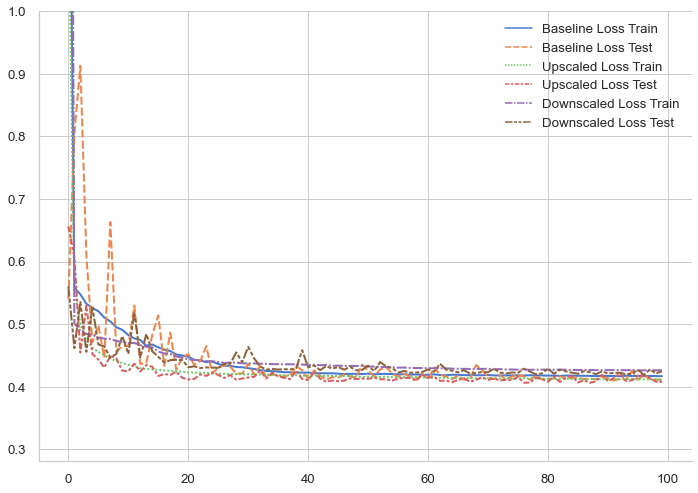

In [113]:
loss_data = pd.DataFrame({'Baseline Loss Train':log_noscale.history['loss'], 'Baseline Loss Test':log_noscale.history['val_loss'], 'Upscaled Loss Train': log_upscaled.history['loss'], 'Upscaled Loss Test': log_upscaled.history['val_loss'], 'Downscaled Loss Train': log_downscaled.history['loss'], 'Downscaled Loss Test': log_downscaled.history['val_loss']})
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.set_style("whitegrid")
sns.despine()
sns.set_context('notebook', font_scale=1.2)
ax = sns.lineplot(data=loss_data, linewidth=2, palette='muted')
ax.axes.set_ylim(None,1)

(0.3680423235850336, 0.7)

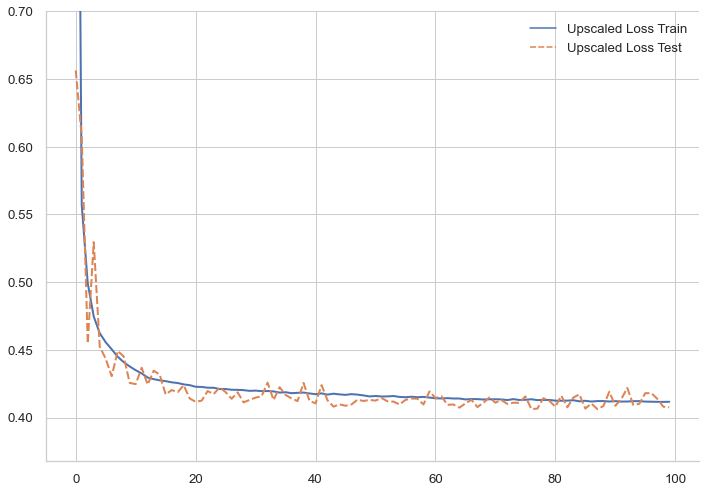

In [237]:
loss_data = pd.DataFrame({'Upscaled Loss Train': log_upscaled.history['loss'], 'Upscaled Loss Test': log_upscaled.history['val_loss']})
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.set_style("whitegrid")
sns.despine()
sns.set_context('notebook', font_scale=1.2)
ax = sns.lineplot(data=loss_data, linewidth=2)
ax.axes.set_ylim(None,0.7)

In [ ]:
loss_data = pd.DataFrame({'Baseline Loss Train':log_noscale.history['loss'], 'Baseline Loss Test':log_noscale.history['val_loss']})
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.set_style("whitegrid")
sns.despine()
sns.set_context('notebook', font_scale=1.2)
ax = sns.lineplot(data=loss_data, linewidth=2)
ax.axes.set_ylim(None,1)

In [238]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=18, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_baseline()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=3, shuffle=True)

log = History()

model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), callbacks=[log], verbose=1)


r = model.predict(x_test)
r_round = [round(test[0]) for test in r]

successes = 0
for result, value in zip(r_round, y_test):
    if result == value:
        successes+=1
accuracy = abs(round((((len(r_round) - successes)/ len(r_round)) * 100) - 100, 5))

print("Accurate predictions:", successes)
print("Accuracy:", accuracy, "%")

Train on 158635 samples, validate on 67987 samples
Epoch 1/50
158635/158635 [==============================] - 6s 38us/step - loss: 0.9413 - accuracy: 0.6707 - val_loss: 0.5384 - val_accuracy: 0.7426
Epoch 2/50
158635/158635 [==============================] - 6s 36us/step - loss: 0.5232 - accuracy: 0.7491 - val_loss: 0.4881 - val_accuracy: 0.7706
Epoch 3/50
158635/158635 [==============================] - 5s 33us/step - loss: 0.4703 - accuracy: 0.7849 - val_loss: 0.4318 - val_accuracy: 0.8194
Epoch 4/50
158635/158635 [==============================] - 5s 34us/step - loss: 0.4489 - accuracy: 0.8008 - val_loss: 0.4367 - val_accuracy: 0.8117
Epoch 5/50
158635/158635 [==============================] - 5s 34us/step - loss: 0.4436 - accuracy: 0.8070 - val_loss: 0.4550 - val_accuracy: 0.7934
Epoch 6/50
158635/158635 [==============================] - 5s 33us/step - loss: 0.4380 - accuracy: 0.8097 - val_loss: 0.4289 - val_accuracy: 0.8162
Epoch 7/50
158635/158635 [=============================

In [260]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=18, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_standardised = create_baseline()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=3, shuffle=True)

standard = StandardScaler()

x_train = standard.fit_transform(x_train)
x_test = standard.fit_transform(x_test)

log_standardised = History()
model_standardised.fit(x_train, y_train, epochs=200, batch_size=256, 
                       validation_data=(x_test, y_test), callbacks=[log_standardised], verbose=1)


r = model_standardised.predict(x_test)
r_round = [round(test[0]) for test in r]

successes = 0
for result, value in zip(r_round, y_test):
    if result == value:
        successes+=1
accuracy = abs(round((((len(r_round) - successes)/ len(r_round)) * 100) - 100, 5))

print("Accurate predictions:", successes)
print("Accuracy:", accuracy, "%")

Train on 158635 samples, validate on 67987 samples
Epoch 1/200
158635/158635 [==============================] - 1s 7us/step - loss: 0.4756 - accuracy: 0.7820 - val_loss: 0.4172 - val_accuracy: 0.8258
Epoch 2/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.4238 - accuracy: 0.8208 - val_loss: 0.4087 - val_accuracy: 0.8296
Epoch 3/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.4168 - accuracy: 0.8254 - val_loss: 0.4055 - val_accuracy: 0.8306
Epoch 4/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.4128 - accuracy: 0.8265 - val_loss: 0.4029 - val_accuracy: 0.8329
Epoch 5/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.4094 - accuracy: 0.8287 - val_loss: 0.4011 - val_accuracy: 0.8335
Epoch 6/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.4069 - accuracy: 0.8294 - val_loss: 0.4000 - val_accuracy: 0.8338
Epoch 7/200
158635/158635 [============================

158635/158635 [==============================] - 1s 6us/step - loss: 0.3936 - accuracy: 0.8339 - val_loss: 0.3911 - val_accuracy: 0.8368
Epoch 56/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3938 - accuracy: 0.8336 - val_loss: 0.3904 - val_accuracy: 0.8368
Epoch 57/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3942 - accuracy: 0.8336 - val_loss: 0.3909 - val_accuracy: 0.8364
Epoch 58/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3942 - accuracy: 0.8338 - val_loss: 0.3915 - val_accuracy: 0.8370
Epoch 59/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3936 - accuracy: 0.8336 - val_loss: 0.3901 - val_accuracy: 0.8372
Epoch 60/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3937 - accuracy: 0.8341 - val_loss: 0.3911 - val_accuracy: 0.8371
Epoch 61/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3937 - accuracy: 0.8335 - val

158635/158635 [==============================] - 1s 6us/step - loss: 0.3921 - accuracy: 0.8347 - val_loss: 0.3896 - val_accuracy: 0.8369
Epoch 110/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3915 - accuracy: 0.8345 - val_loss: 0.3905 - val_accuracy: 0.8375
Epoch 111/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3919 - accuracy: 0.8349 - val_loss: 0.3899 - val_accuracy: 0.8377
Epoch 112/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3920 - accuracy: 0.8343 - val_loss: 0.3900 - val_accuracy: 0.8369
Epoch 113/200
158635/158635 [==============================] - 1s 7us/step - loss: 0.3917 - accuracy: 0.8346 - val_loss: 0.3897 - val_accuracy: 0.8380
Epoch 114/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3918 - accuracy: 0.8342 - val_loss: 0.3897 - val_accuracy: 0.8373
Epoch 115/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3913 - accuracy: 0.8350

158635/158635 [==============================] - 1s 6us/step - loss: 0.3903 - accuracy: 0.8350 - val_loss: 0.3894 - val_accuracy: 0.8377
Epoch 164/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3909 - accuracy: 0.8349 - val_loss: 0.3900 - val_accuracy: 0.8375
Epoch 165/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3905 - accuracy: 0.8352 - val_loss: 0.3895 - val_accuracy: 0.8372
Epoch 166/200
158635/158635 [==============================] - 1s 7us/step - loss: 0.3906 - accuracy: 0.8351 - val_loss: 0.3896 - val_accuracy: 0.8370
Epoch 167/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3907 - accuracy: 0.8350 - val_loss: 0.3894 - val_accuracy: 0.8370
Epoch 168/200
158635/158635 [==============================] - 1s 7us/step - loss: 0.3908 - accuracy: 0.8347 - val_loss: 0.3914 - val_accuracy: 0.8365
Epoch 169/200
158635/158635 [==============================] - 1s 6us/step - loss: 0.3901 - accuracy: 0.8356

In [241]:
print(log.params)
print(log_standardised.params)
print(log_normalised.params)

{'batch_size': 32, 'epochs': 50, 'steps': None, 'samples': 158635, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}
{'batch_size': 32, 'epochs': 50, 'steps': None, 'samples': 158635, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}
{'batch_size': 32, 'epochs': 50, 'steps': None, 'samples': 158635, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}


(0.38043164582599504, 1.0)

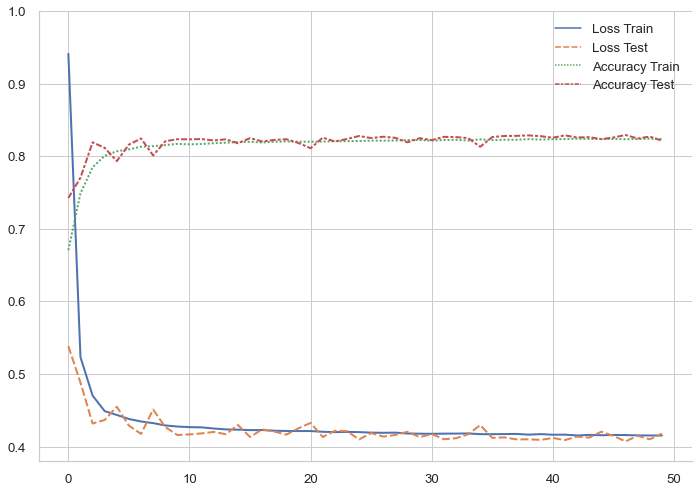

In [242]:
log_data = pd.DataFrame({'Loss Train': log.history['loss'], 'Loss Test': log.history['val_loss'], 'Accuracy Train': log.history['accuracy'], 'Accuracy Test': log.history['val_accuracy']})
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.set_style("whitegrid")
sns.despine()
sns.set_context('notebook', font_scale=1.2)
ax = sns.lineplot(data=log_data, linewidth=2)
ax.axes.set_ylim(None,1)

(0.3842055203682494, 0.4799881978156841)

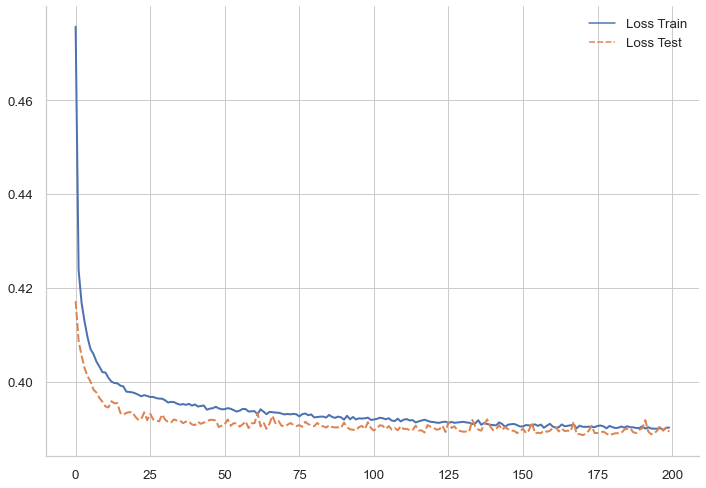

In [261]:
log_data = pd.DataFrame({'Loss Train': log_standardised.history['loss'], 'Loss Test': log_standardised.history['val_loss']})
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.set_style("whitegrid")
sns.despine()
sns.set_context('notebook', font_scale=1.2)
ax = sns.lineplot(data=log_data, linewidth=2)
ax.axes.set_ylim(None,None)

(0.7792146980762482, 0.8408284604549408)

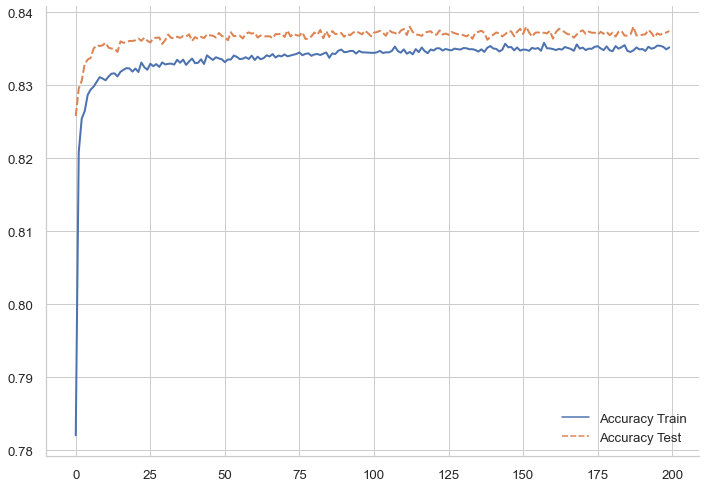

In [262]:
log_data = pd.DataFrame({'Accuracy Train': log_standardised.history['accuracy'], 'Accuracy Test': log_standardised.history['val_accuracy']})
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.set_style("whitegrid")
sns.despine()
sns.set_context('notebook', font_scale=1.2)
ax = sns.lineplot(data=log_data, linewidth=2)
ax.axes.set_ylim(None,None)

In [ ]:
, 'Accuracy Train': log_standardised.history['accuracy'], 'Accuracy Test': log_standardised.history['val_accuracy']

, 'Accuracy Train': log_b.history['accuracy'], 'Accuracy Test': log_b.history['val_accuracy']

, 'Upscaled Accuracy Train': log_upscaled.history['accuracy'], 'Upscaled Accuracy Test': log_upscaled.history['val_accuracy']